In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

D:\anaconda\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\pyth

images/dog.jpg


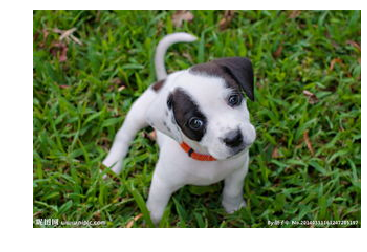

Staffordshire bullterrier, Staffordshire bull terrier (score = 0.60769)
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier (score = 0.22433)
toy terrier (score = 0.02480)
French bulldog (score = 0.01559)
Chihuahua (score = 0.01524)

images/glass6.jpg


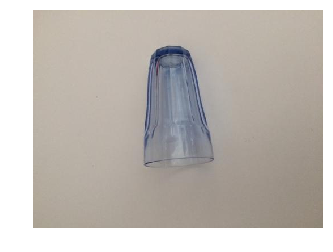

saltshaker, salt shaker (score = 0.79037)
pop bottle, soda bottle (score = 0.02932)
vase (score = 0.01789)
pitcher, ewer (score = 0.01069)
nipple (score = 0.00797)



In [2]:
#  coding: utf-8

class NodeLookup(object):
    def __init__(self):  
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'   
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path,  uid_lookup_path)

    def load(self,  label_lookup_path,  uid_lookup_path):
        #  加载分类字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        # 一行一行读取数据
        for line in proto_as_ascii_lines:
            # 去掉换行符
            line=line.strip('\n')
            # 按照'\t'分割
            parsed_items = line.split('\t')
            # 获取分类编号
            uid = parsed_items[0]
            # 获取分类名称
            human_string = parsed_items[1]
            # 保存编号字符串n********与分类名称映射关系
            uid_to_human[uid] = human_string

        #  加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                # 获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                # 获取编号字符串n********
                target_class_string = line.split(': ')[1]
                # 保存分类编号1-1000与编号字符串n********映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # 建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key,  val in node_id_to_uid.items():
            # 获取分类名称
            name = uid_to_human[val]
            # 建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name

    # 传入分类编号1-1000返回分类名称
    def id_to_string(self,  node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


# 创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb',  'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,  name='')


with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # 遍历目录
    for root, dirs, files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root, file),  'rb').read()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})  # 图片格式是jpg格式
            predictions = np.squeeze(predictions)  # 把结果转为1维数据

            # 打印图片路径及名称
            image_path = os.path.join(root, file)
            print(image_path)
            # 显示图片
            img=Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # 排序
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:     
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取该分类的置信度
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string,  score))
            print()
